In [1]:
import json
from pprint import pprint

## need client secret to get gmail credentials
## download from the google python quickstart guide
with open('client_secret.json') as data_file:    
    credentials = json.load(data_file)
client_id = credentials['installed']['client_id']
client_secret = credentials['installed']['client_secret']

In [2]:
import oauth2client.client, oauth2client.file, oauth2client.tools
import gspread

flow = oauth2client.client.OAuth2WebServerFlow(client_id, client_secret, 'https://spreadsheets.google.com/feeds')
storage = oauth2client.file.Storage('credentials.dat')
credentials = storage.get()
if credentials is None or credentials.invalid:
    import argparse
    flags = argparse.ArgumentParser(parents=[oauth2client.tools.argparser]).parse_args([])
    credentials = oauth2client.tools.run_flow(flow, storage, flags)

gc = gspread.authorize(credentials)

# when this cell is run, your browser will take you to a Google authorization page.
# this authorization is complete, the credentials will be cached in a file named credentials.dat

In [3]:
import pandas as pd
# open the spreadsheet and preserve the column order in the dataframe
sheet = gc.open("Eric NYC Information")
worksheet = sheet.worksheet("Daily Spending")
headers = worksheet.row_values(1)
headers = list(filter(None, headers))
df = pd.DataFrame(worksheet.get_all_records())[headers]
# also, get the value for the daily budgeted spending
daily_budgeted_spending = float(sheet.worksheet("Updated Budget").acell("F40").value.replace("$",""))
print("Daily spending budget is {0}".format(daily_budgeted_spending))

Daily spending budget is 57.61


In [4]:
# update type of the Date column. Can only run this once.
df['datetime'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df.dtypes

Date                           object
Month                           int64
Day of Week                    object
Month Identifier               object
Item                           object
Price                          object
Main Category                  object
Sub-Category                   object
Cumulative Spending            object
Cumulative Days                 int64
Deficit                        object
datetime               datetime64[ns]
dtype: object

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df['Price'] = df['Price'].astype(str).apply(lambda x: str(x).strip("$"))
def remove_dollar_sign(s):
    return s.replace("$", "").replace(",", "")
df['Price'] = df['Price'].apply(remove_dollar_sign)
df['Price'] = pd.to_numeric(df['Price'])
df['cSpend'] = df['Price'].cumsum()
df['Cumulative Days'] = pd.to_numeric(df['Cumulative Days'])
df['Cumulative Deficit'] = (df['cSpend'] - daily_budgeted_spending*df['Cumulative Days']).round(2)
try:
    df = df.drop(['Month', 'Month Identifier', 'Deficit', 'Date', 'Cumulative Spending'], 1)
except:
    print("already dropped the columns")
df.tail()

Day of Week                   Item  Price              Main Category  \
1421    Saturday  Lyft home from leah's  10.23  Travel and Transportation   
1422      Sunday            Whole Foods  39.68                       Food   
1423      Monday                Korilla  11.00                       Food   
1424      Monday          Shaving Cream   4.80              Home Supplies   
1425      Monday              Jet order   4.65              Home Supplies   

        Sub-Category  Cumulative Days   datetime        cSpend  \
1421            Cabs              391 2017-08-05  23411.566667   
1422       Groceries              392 2017-08-06  23451.246667   
1423            Fast              393 2017-08-07  23462.246667   
1424      Toiletries              393 2017-08-07  23467.046667   
1425  House Supplies              393 2017-08-07  23471.696667   

      Cumulative Deficit  
1421              886.06  
1422              868.13  
1423              821.52  
1424              826.32  
1425              830.97

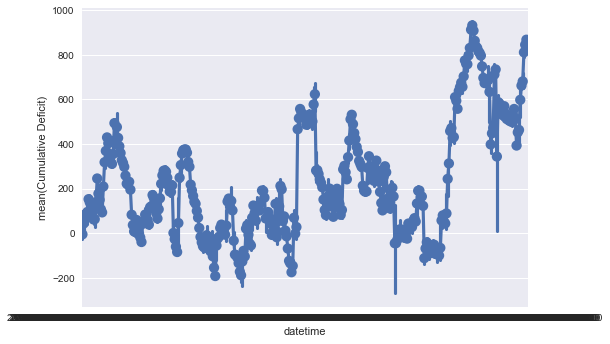

In [7]:
# graph cumulative deficit

sns.pointplot(x = "datetime", y="Cumulative Deficit", data = df)
plt.show()

23468.0


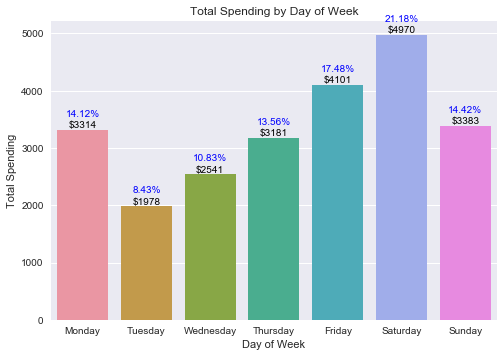

In [8]:
## let's compare spending by weekday
weeks_df = df.groupby(['Day of Week'], as_index=False ).sum()

# define mapping of weekday order
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = weeks_df['Day of Week'].map(mapping)
weeks_df = weeks_df.iloc[key.argsort()] # sort the dataframe on the mapping
ax = sns.barplot(x='Day of Week', y="Price", data = weeks_df)
ax.set(xlabel='Day of Week', ylabel='Total Spending', title="Total Spending by Day of Week")

## trying to label the days with amounts and proportions
total_spend = float(sum([int(p.get_height()) for p in ax.patches]))
print(total_spend)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '$%d' % int(p.get_height()), 
            fontsize=10, color='black', ha='center', va='bottom')
    percentage = (str(round(float(100*p.get_height()) / total_spend,2))+ "%")
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+200, percentage, 
            fontsize=10, color='blue', ha='center', va='bottom')
plt.show()

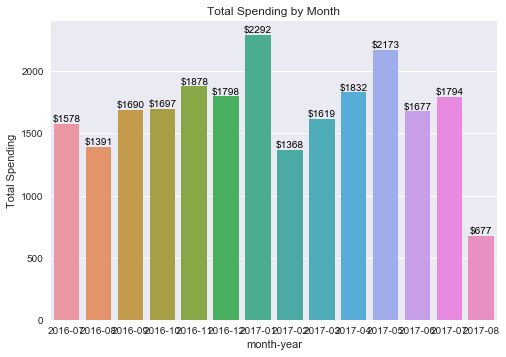

In [9]:
## let's compare spending by Month
df['month-year'] = df['datetime'].dt.strftime('%Y-%m')

month_df = df.groupby(['month-year'], as_index=False ).sum()

ax = sns.barplot(x='month-year', y="Price", data = month_df)
ax.set(xlabel='month-year', ylabel='Total Spending', title="Total Spending by Month")

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '$%d' % int(p.get_height()), 
            fontsize=10, color='black', ha='center', va='bottom')

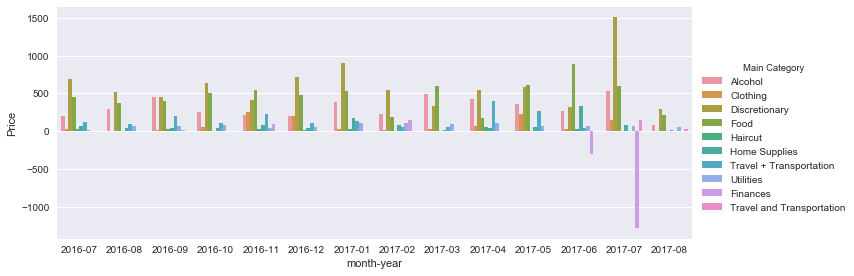

In [10]:
months_categories_df = df.groupby(['month-year', 'Main Category'],as_index=False ).sum()
sns.factorplot(x='month-year', y='Price', data=months_categories_df, hue='Main Category', kind='bar', aspect = 2.5)

In [11]:
months_categories_df.pivot_table(index='month-year', columns='Main Category', values='Price').plot.bar(stacked=True)

In [12]:
#figsize(40,40)
#sns.factorplot(x="Main Category", y="Price", col="month-year", data=months_categories_df, saturation=.5, kind="bar", ci=None, aspect=.6, col_wrap =2)
months_categories_df.head()


month-year  Main Category   Price  Cumulative Days    cSpend  \
0    2016-07        Alcohol  195.39              226  16077.37   
1    2016-07       Clothing   25.00               23   1437.47   
2    2016-07  Discretionary  683.72              260  18659.20   
3    2016-07           Food  449.94              573  39398.54   
4    2016-07        Haircut   25.00               20   1385.61   

   Cumulative Deficit  
0             3057.51  
1              112.44  
2             3680.60  
3             6388.01  
4              233.41

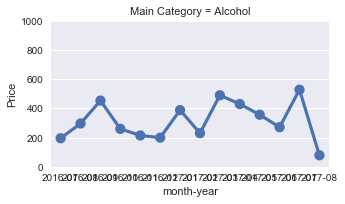

In [13]:
alcohol_df = months_categories_df[months_categories_df['Main Category'] == 'Alcohol' ]
alcohol_df.head()

g = sns.FacetGrid(alcohol_df, col="Main Category", col_wrap=2, size=3, ylim=(0,1000), aspect = 1.5)
g = (g.map(sns.pointplot, "month-year", "Price"))

In [14]:
g = sns.factorplot(x="month-year", y="Price", col="Main Category", data=months_categories_df,col_wrap=3)

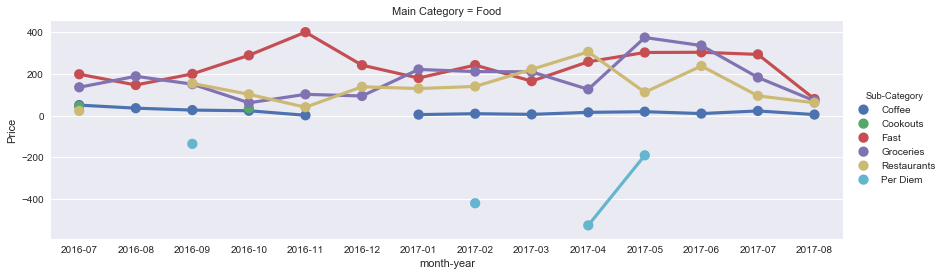

In [15]:
## drill down into sub categories
## let's see how food spending has varied over the months

months_sub_categories_df = df.groupby(['month-year', 'Main Category', 'Sub-Category'],as_index=False ).sum()
food_sub_categories_df = months_sub_categories_df[months_sub_categories_df['Main Category'] == "Food"]
g = sns.factorplot(x="month-year", y="Price", col="Main Category", hue = "Sub-Category", data=food_sub_categories_df,col_wrap=1, aspect = 3)


In [16]:
## let's see how discretionary spending has changed

discretionary_sub_categories_df = months_sub_categories_df[months_sub_categories_df['Main Category'] == "Discretionary"]
g = sns.factorplot(x="month-year", y="Price", col="Main Category", hue = "Sub-Category", kind='bar', data=discretionary_sub_categories_df,col_wrap=1, aspect = 3)

In [17]:
## let's see how discretionary spending has changed

alcohol_sub_categories_df = months_sub_categories_df[months_sub_categories_df['Main Category'] == "Alcohol"]
g = sns.factorplot(x="month-year", y="Price", col="Main Category", hue = "Sub-Category", data=alcohol_sub_categories_df, kind="bar",col_wrap=1, aspect = 3)

ax = plt.gca()
# Iterate through the list of axes' patches
# iterates through one series at a time. in this instance, iterates through "Bar" and then "Personal"
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '$%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

In [18]:
## let's get the mean monthly spending for each main category

categories = df['Main Category'].unique()
print(categories)

['Food' 'Alcohol' 'Home Supplies' 'Discretionary' 'Travel + Transportation'
 'Clothing' 'Utilities' 'Haircut' 'Finances' 'Travel and Transportation']


In [19]:
food_price_series = df[df['Main Category'] == "Food"]['Price']
print(type(food_price_series))
sns.distplot(food_price_series)
food_price_series.describe()

<class 'pandas.core.series.Series'>


count    630.000000
mean      10.393825
std       32.957777
min     -527.340000
25%        4.272500
50%        8.000000
75%       13.232500
max      152.500000
Name: Price, dtype: float64

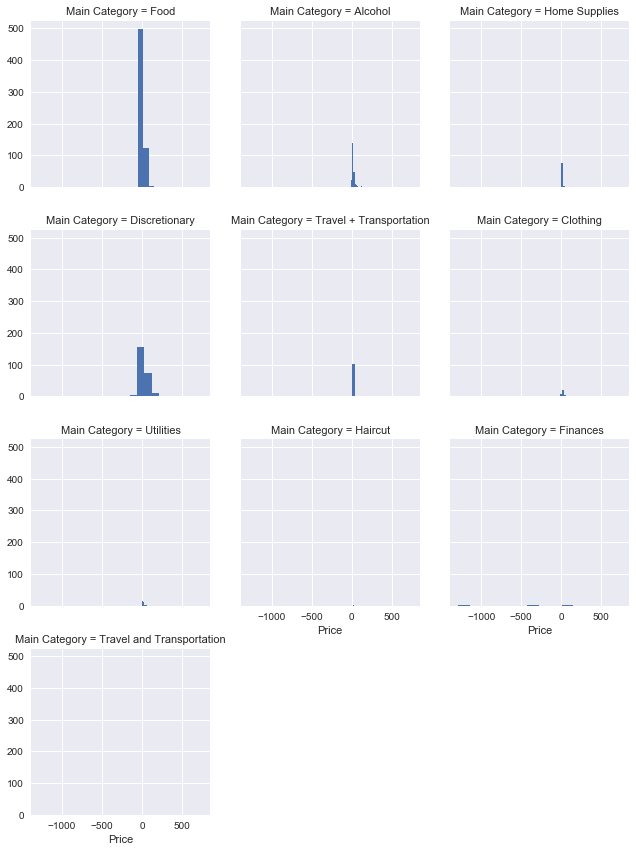

In [20]:
g = sns.FacetGrid(df, col="Main Category", col_wrap = 3)
g = g.map(plt.hist, "Price")

In [21]:
## let's examine the COUNT of spending in each main category

count_by_category_df = df.groupby(['Main Category'],as_index=False ).count()

dummy_df = df.copy(deep=True)

def update_TNT (s):
    if s == "Travel + Transportation":
        return "Travel and Transportation"
dummy_df['Main Category'].replace(to_replace="Travel + Transportation", value="Travel + Transportation")
print("'"+df.iloc[14]['Main Category']+"'")

'Travel + Transportation'


In [22]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

data = [Bar(x=month_df['month-year'],
            y=month_df['Price'])]

layout = Layout(
    showlegend=True,
    height=600,
    width=600,
)

fig = dict( data=data, layout=layout )

iplot(fig)  


In [25]:
# need to pivot so left hand column is months
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=False, theme='ggplot')

pivoted = months_categories_df.pivot_table(index='month-year', columns='Main Category', values='Price')
cats = list(filter(None, list(pivoted.columns.values)))
pivoted = pivoted[cats]



fig = pivoted.iplot(kind='bar', barmode='stack', asFigure = True)
fig['layout'].title = 'Stacked Bar Plot - Spending by Main Category by Month'
fig['layout']['xaxis']['tickangle'] = -45

pprint(fig['layout']['xaxis'])
iplot(fig)

pprint (cf.getThemes())

{'tickangle': -45}


['ggplot', 'pearl', 'solar', 'space', 'white', 'polar', 'henanigans']


In [52]:
fig2 = pivoted.iplot(asFigure=True,
                               kind='scatter',xTitle='Dates',yTitle='Spending',title='Spending by Main Category by Month')



fig2['layout'].title = 'Stacked Bar Plot - Spending by Main Category by Month'
fig2['layout']['xaxis']['tickangle'] = -45

iplot(fig2)